# Loading libraries

In [1]:
import sys
import os
import yaml
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from data_formatter.base import *

# Check statistics of the data

In [2]:
import matplotlib.pyplot as plt

# load yaml config file
with open('./config/dubosson.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
   id                time     gl  time_year  time_month  time_day  time_hour  \
0   0 2014-10-01 19:14:00  185.4       2014          10         1         19   

   time_minute  
0           14  


ValueError: Overlapping times in id 0

Train segment lengths:
	Min:  183
	Max:  1413
	Median:  969.0
	Mean:  882.0
	Std:  389.09724577111393


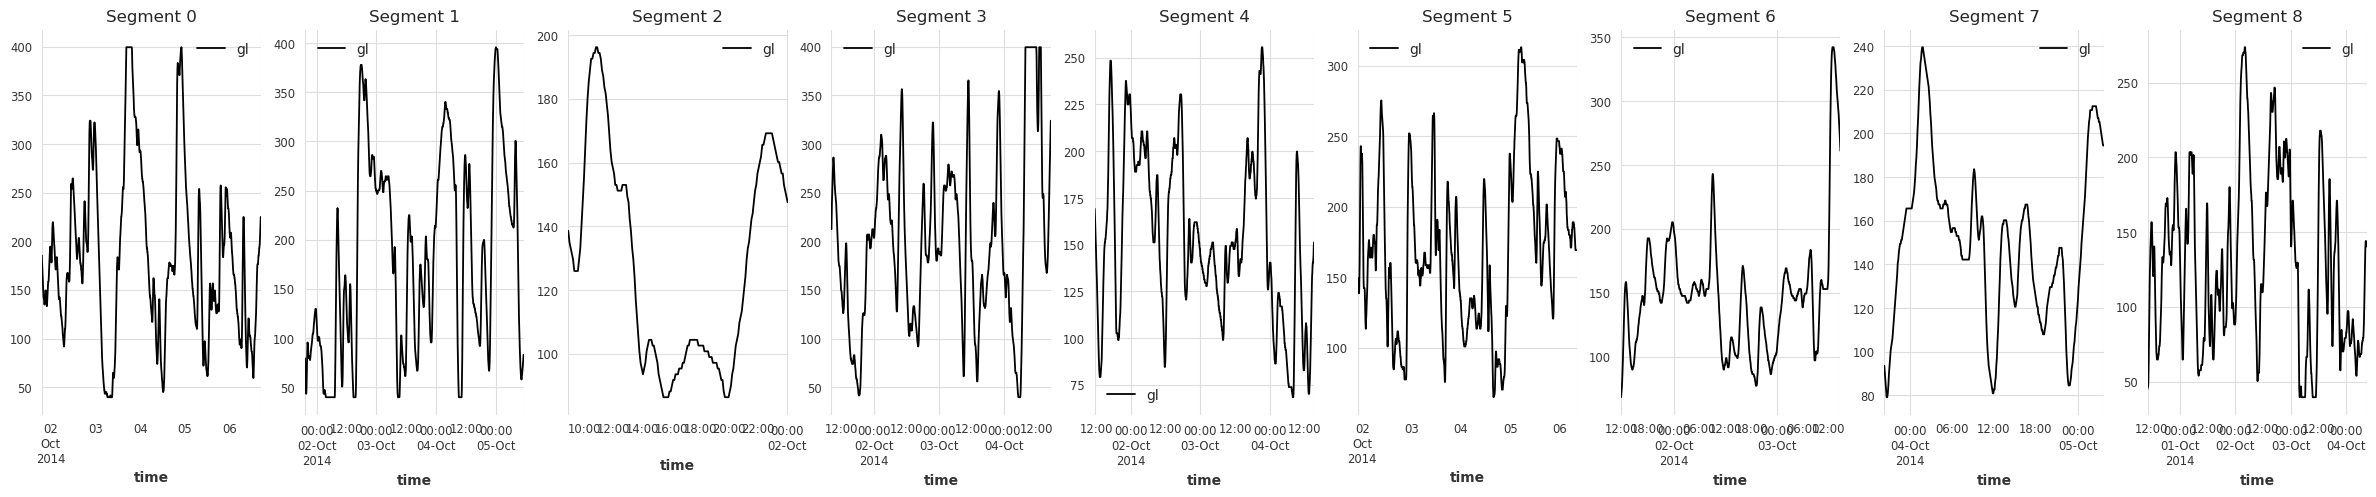

In [3]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot each segment
num_segments = formatter.train_data['id_segment'].nunique()
fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(formatter.train_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))

Segment 2 is too short


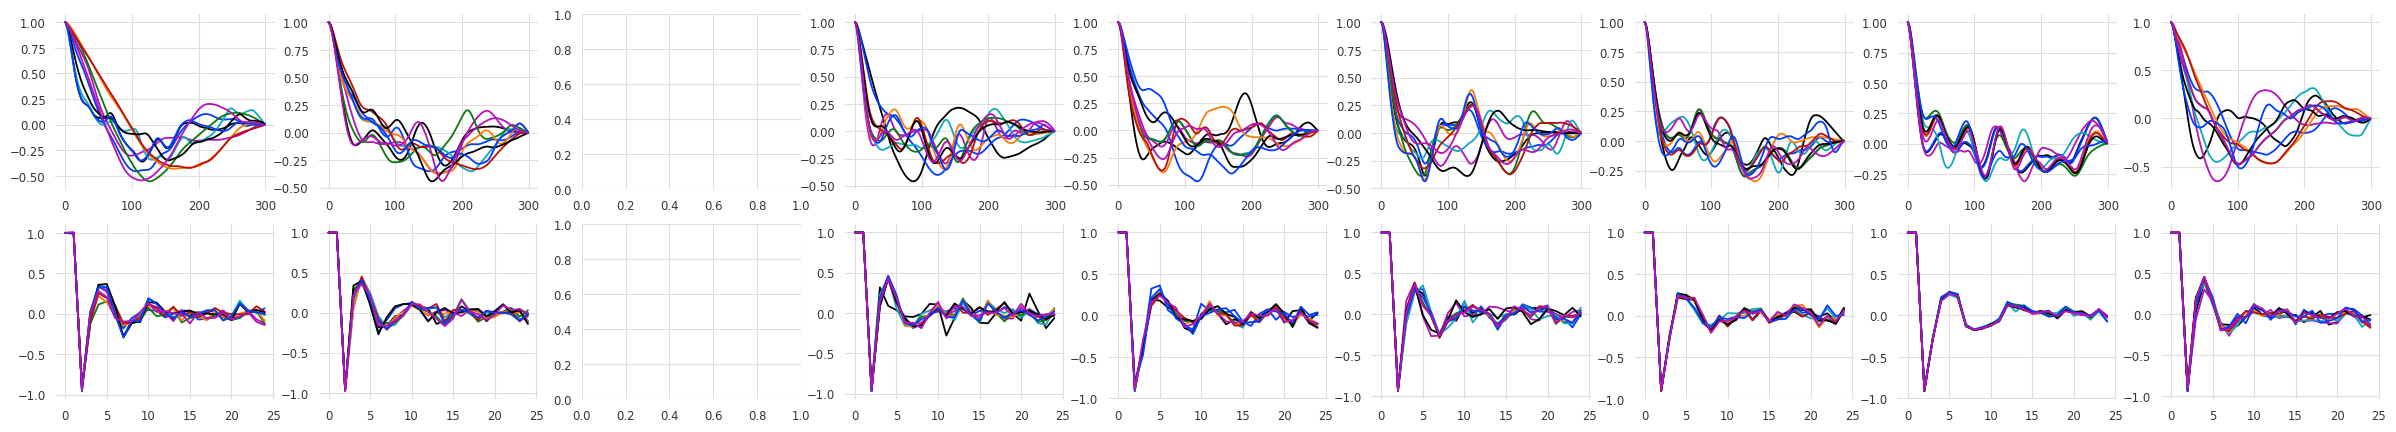

In [4]:
# plot acf of random samples from segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300
for i, (group, data) in enumerate(formatter.train_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    # select 10 random samples from index of data
    sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
    # plot acf / pacf of each sample
    for j in sample:
        acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
        pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
        ax[0, i].plot(acf)
        ax[1, i].plot(pacf)


# Change the config according to the observations above

In [5]:
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 30
config['interpolation_params']['min_drop_length'] = 240
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 240
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 1
	Extracted segments: 8
Splitting data...
	Train: 3975 (60.09%)
	Val: 1440 (21.77%)
	Test: 2340 (35.37%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


# Models

## Convert data and (optional) scaling

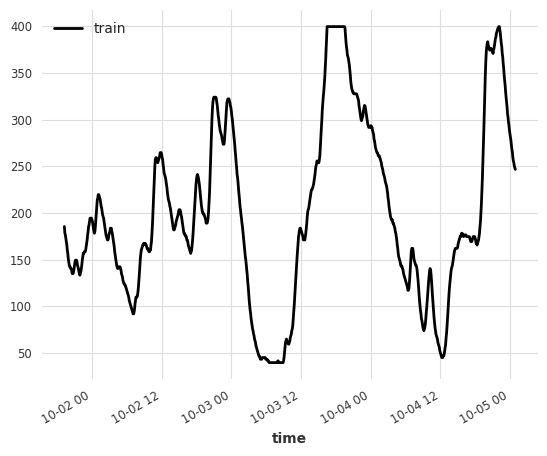

In [6]:
# build target series
target_col = formatter.get_column('target')
time_col = formatter.get_column('time')
group_col = formatter.get_column('sid')
train_series = TimeSeries.from_group_dataframe(formatter.train_data, 
                                               group_cols = group_col, 
                                               time_col = time_col, 
                                               value_cols = target_col)
val_series = TimeSeries.from_group_dataframe(formatter.val_data,
                                             group_cols = group_col,
                                             time_col = time_col,
                                             value_cols = target_col)
test_series = TimeSeries.from_group_dataframe(formatter.test_data,
                                              group_cols = group_col,
                                              time_col = time_col,
                                              value_cols = target_col)

# build static covariates series
static_cols = formatter.get_column('static_covs')
if static_cols is not None:
    static_cols += [formatter.get_column('id')]
else:
    static_cols = [formatter.get_column('id')]
train_static = TimeSeries.from_group_dataframe(formatter.train_data, 
                                               group_cols = group_col, 
                                               time_col = time_col, 
                                               value_cols = static_cols)
val_static = TimeSeries.from_group_dataframe(formatter.val_data,
                                             group_cols = group_col,
                                             time_col = time_col,
                                             value_cols = static_cols)
test_static = TimeSeries.from_group_dataframe(formatter.test_data,
                                              group_cols = group_col,
                                              time_col = time_col,
                                              value_cols = static_cols)

# build dynamic covariates series
dynamic_cols = formatter.get_column('dynamic_covs')
if dynamic_cols is not None:
    train_dynamic = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                    group_cols = group_col, 
                                                    time_col = time_col, 
                                                    value_cols = dynamic_cols)
    val_dynamic = TimeSeries.from_group_dataframe(formatter.val_data,
                                                  group_cols = group_col,
                                                  time_col = time_col,
                                                  value_cols = dynamic_cols)
    test_dynamic = TimeSeries.from_group_dataframe(formatter.test_data,
                                                   group_cols = group_col,
                                                   time_col = time_col,
                                                   value_cols = dynamic_cols)

# build future covariates series
future_cols = formatter.get_column('future_covs')
if future_cols is not None:
    train_future = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                   group_cols = group_col, 
                                                   time_col = time_col, 
                                                   value_cols = future_cols)
    val_future = TimeSeries.from_group_dataframe(formatter.val_data,
                                                 group_cols = group_col,
                                                 time_col = time_col,
                                                 value_cols = future_cols)
    test_future = TimeSeries.from_group_dataframe(formatter.test_data,
                                                  group_cols = group_col,
                                                  time_col = time_col,
                                                  value_cols = future_cols)

train_series[0].plot(label='train')

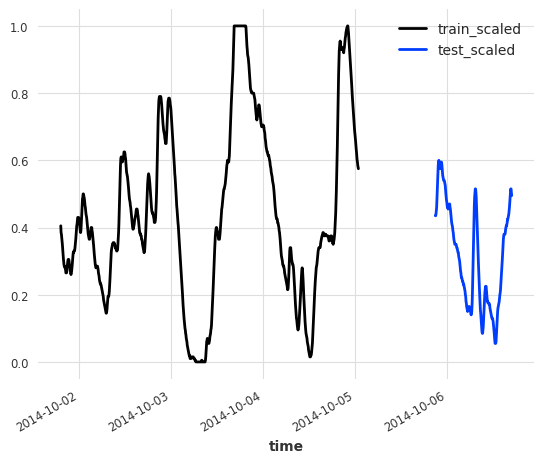

In [7]:
# scale the data
scaler = Scaler()
scaler.fit(train_series)
train_series_scaled = scaler.transform(train_series)
val_series_scaled = scaler.transform(val_series)
test_series_scaled = scaler.transform(test_series)

# scale covariates
scaler_static = Scaler()
if static_cols is not None:
    scaler_static.fit(train_static)
    train_static_scaled = scaler_static.transform(train_static)
    val_static_scaled = scaler_static.transform(val_static)
    test_static_scaled = scaler_static.transform(test_static)

# scale dynamic covariates
scaler_dynamic = Scaler()
if dynamic_cols is not None:
    scaler_dynamic.fit(train_dynamic)
    train_dynamic_scaled = scaler_dynamic.transform(train_dynamic)
    val_dynamic_scaled = scaler_dynamic.transform(val_dynamic)
    test_dynamic_scaled = scaler_dynamic.transform(test_dynamic)

# scale future covariates
scaler_future = Scaler()
if future_cols is not None:
    scaler_future.fit(train_future)
    train_future_scaled = scaler_future.transform(train_future)
    val_future_scaled = scaler_future.transform(val_future)
    test_future_scaled = scaler_future.transform(test_future)

train_series_scaled[0].plot(label='train_scaled')
test_series_scaled[0].plot(label='test_scaled')

## ARIMA

### Preliminary check

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
arima = models.ARIMA(p=1, d=1, q=1, seasonal_order=(0, 0, 0, 0))
forecasts = arima.historical_forecasts(val_series_scaled, 
                                       train_length=156,
                                       forecast_horizon=12,
                                       stride=1,
                                       retrain=True,
                                       last_points_only=True,
                                       verbose=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

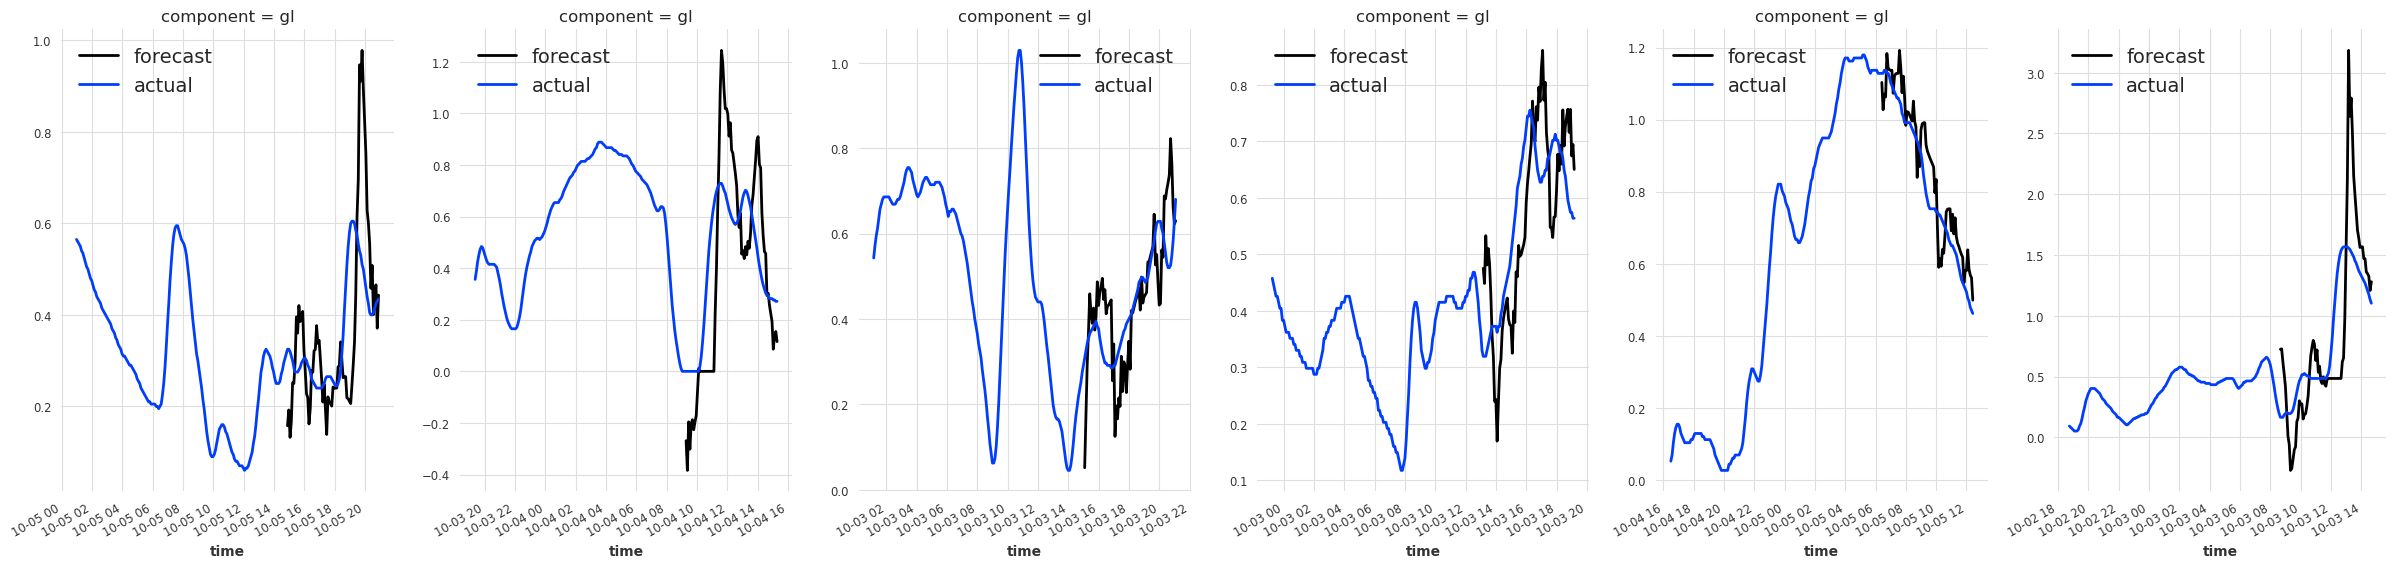

In [10]:
fig, axs = plt.subplots(1, 6, figsize=(30, 6))
for i in range(6):
    forecasts[i].plot(label='forecast', ax=axs[i])
    val_series_scaled[i].plot(label='actual', ax=axs[i])
    axs[i].legend(fontsize=14)

### Hyperparameter search

In [ ]:
arima = models.ARIMA()

# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 96, 204, step=12)
    out_len = 12

    # Hyperparameters
    p = trial.suggest_int("p", 1, 10) # AR terms
    d = trial.suggest_int("d", 1, 10) # Order of differencing
    q = trial.suggest_int("q", 1, 10) # MA terms

    # build the TCN model
    model = models.ARIMA(
        p=p, d=d, q=q,
        seasonal_order=(0, 0, 0, 0)
    )

    # backtest on the validation set
    errors = model.backtest(val_series_scaled,
                            train_length=in_len,
                            forecast_horizon=out_len,
                            stride=1,
                            retrain=True,
                            verbose=False,
                            metric=metrics.rmse,
                            last_points_only=False,
                            )
    avg_error = np.mean(errors)

    return avg_error


# for convenience, print some optimization trials information
def print_callback(study, trial):
    # check that file exists otherwise create it
    if not os.path.exists("dubosson_arima_optimization.txt"):
        with open("dubosson_arima_optimization.txt", "w") as f:
            f.write("")
    # write output to a file
    with open("dubosson_arima_optimization.txt", "a") as f:
        f.write(f"Current value: {trial.value}, Current params: {trial.params}")
        f.write(f"\nBest value: {study.best_value}, Best params: {study.best_trial.params}")

# optimize hyperparameters by minimizing the rmse on the validation set
study = optuna.create_study(direction="minimize")
# import linalg error
study.optimize(objective, n_trials=100, callbacks=[print_callback], catch=(np.linalg.LinAlgError, ))


[I 2023-01-28 10:38:40,296] A new study created in memory with name: no-name-a0c3dc08-eaee-4216-b3ea-780206e0ede0
[I 2023-01-28 10:41:49,298] Trial 0 finished with value: 6.046567465742375 and parameters: {'in_len': 192, 'p': 7, 'd': 8, 'q': 5}. Best is trial 0 with value: 6.046567465742375.
[I 2023-01-28 10:47:51,810] Trial 1 finished with value: 9.130687725114663 and parameters: {'in_len': 144, 'p': 8, 'd': 8, 'q': 6}. Best is trial 0 with value: 6.046567465742375.
[I 2023-01-28 10:54:55,575] Trial 2 finished with value: inf and parameters: {'in_len': 96, 'p': 8, 'd': 6, 'q': 4}. Best is trial 0 with value: 6.046567465742375.
[I 2023-01-28 10:58:37,826] Trial 3 finished with value: 0.10084927249300683 and parameters: {'in_len': 96, 'p': 4, 'd': 2, 'q': 5}. Best is trial 3 with value: 0.10084927249300683.


### Performance

In [ ]:
from typing import Any, BinaryIO, Callable, Dict, List, Optional, Sequence, Tuple, Union
def backtest_and_save(series: Union[TimeSeries, Sequence[TimeSeries]],
                      forecasts: Union[TimeSeries, Sequence[TimeSeries]], 
                      scaler: Any,
                      metric: Union[
                                Callable[[TimeSeries, TimeSeries], float],
                                List[Callable[[TimeSeries, TimeSeries], float]],
                              ], 
                      reduction: Union[Callable[[np.ndarray], float], None] = np.mean
                      ):
    """
    Backtest the forecasts on the series and save the results to a csv file.

    Parameters
    ----------
    series
        The target time series.
    forecasts
        The forecasts.
    scaler
        The scaler used to scale the series.
    metric
        The metric to use for backtesting.
    reduction
        The reduction to apply to the metric.

    Returns
    -------
    float or List[float] or List[List[float]]
        The (sequence of) error score on a series, or list of list containing error scores for each
        provided series and each sample.
    """
    series = [series] if isinstance(series, TimeSeries) else series
    if len(series) == 1:
        forecasts = [forecasts]

    if not isinstance(metric, list):
        metric = [metric]

    # reverse scaling and pickle forecasts and true values
    for idx, target_ts in enumerate(series):
         


    backtest_list = []
    for idx, target_ts in enumerate(series):
        errors = [
            [metric_f(target_ts, f) for metric_f in metric]
            if len(metric) > 1
            else metric[0](target_ts, f)
            for f in forecasts[idx]
        ]

        if reduction is None:
            backtest_list.append(errors)
        else:
            backtest_list.append(reduction(np.array(errors), axis=0))

    # pickle forecasts and true values


    return backtest_list if len(backtest_list) > 1 else backtest_list[0]

In [ ]:
# number of simulations
nreps = 100
# generate 100 random states
random_states = np.random.randint(0, 10000, size=nreps)
for i in range(100):
    # reload data set with a chosen random state
    config['random_state'] = random_states[i]
    formatter = DataFormatter(config)
    
    # build target series
    target_col = formatter.get_column('target')
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    train_series = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                group_cols = group_col, 
                                                time_col = time_col, 
                                                value_cols = target_col)
    val_series = TimeSeries.from_group_dataframe(formatter.val_data,
                                                group_cols = group_col,
                                                time_col = time_col,
                                                value_cols = target_col)
    test_series = TimeSeries.from_group_dataframe(formatter.test_data,
                                                group_cols = group_col,
                                                time_col = time_col,
                                                value_cols = target_col)

    # build static covariates series
    static_cols = formatter.get_column('static_covs')
    if static_cols is not None:
        static_cols += [formatter.get_column('id')]
    else:
        static_cols = [formatter.get_column('id')]
    train_static = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                group_cols = group_col, 
                                                time_col = time_col, 
                                                value_cols = static_cols)
    val_static = TimeSeries.from_group_dataframe(formatter.val_data,
                                                group_cols = group_col,
                                                time_col = time_col,
                                                value_cols = static_cols)
    test_static = TimeSeries.from_group_dataframe(formatter.test_data,
                                                group_cols = group_col,
                                                time_col = time_col,
                                                value_cols = static_cols)

    # build dynamic covariates series
    dynamic_cols = formatter.get_column('dynamic_covs')
    if dynamic_cols is not None:
        train_dynamic = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                        group_cols = group_col, 
                                                        time_col = time_col, 
                                                        value_cols = dynamic_cols)
        val_dynamic = TimeSeries.from_group_dataframe(formatter.val_data,
                                                    group_cols = group_col,
                                                    time_col = time_col,
                                                    value_cols = dynamic_cols)
        test_dynamic = TimeSeries.from_group_dataframe(formatter.test_data,
                                                    group_cols = group_col,
                                                    time_col = time_col,
                                                    value_cols = dynamic_cols)

    # build future covariates series
    future_cols = formatter.get_column('future_covs')
    if future_cols is not None:
        train_future = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                    group_cols = group_col, 
                                                    time_col = time_col, 
                                                    value_cols = future_cols)
        val_future = TimeSeries.from_group_dataframe(formatter.val_data,
                                                    group_cols = group_col,
                                                    time_col = time_col,
                                                    value_cols = future_cols)
        test_future = TimeSeries.from_group_dataframe(formatter.test_data,
                                                    group_cols = group_col,
                                                    time_col = time_col,
                                                    value_cols = future_cols)

    # scale the data
    scaler = Scaler()
    scaler.fit(train_series)
    train_series_scaled = scaler.transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    test_series_scaled = scaler.transform(test_series)

    # scale covariates
    scaler_static = Scaler()
    if static_cols is not None:
        scaler_static.fit(train_static)
        train_static_scaled = scaler_static.transform(train_static)
        val_static_scaled = scaler_static.transform(val_static)
        test_static_scaled = scaler_static.transform(test_static)

    # scale dynamic covariates
    scaler_dynamic = Scaler()
    if dynamic_cols is not None:
        scaler_dynamic.fit(train_dynamic)
        train_dynamic_scaled = scaler_dynamic.transform(train_dynamic)
        val_dynamic_scaled = scaler_dynamic.transform(val_dynamic)
        test_dynamic_scaled = scaler_dynamic.transform(test_dynamic)

    # scale future covariates
    scaler_future = Scaler()
    if future_cols is not None:
        scaler_future.fit(train_future)
        train_future_scaled = scaler_future.transform(train_future)
        val_future_scaled = scaler_future.transform(val_future)
        test_future_scaled = scaler_future.transform(test_future)

    # build the model with best hyperparameters
    arima = models.ARIMA(p=1, d=1, q=1, seasonal_order=(0, 0, 0, 0))